# 1D Example from Boninsegna & Clementi (2018)

This notebook attempts to reproduce the 1D example from L. Boninsegna and C. Clementi, “Sparse learning of stochastic dynamical equations,” J. Chem. Phys., vol. 148, p. 241723, 2018.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataprep import *
from stochastic_sindy import *

import multiprocessing as mp # for simulating trajectories faster

## Time series

The form of the potential being used is
$$
U(x) = \frac{x^4}{2} - 4 x^3 + 9 x^2 -3 x,
$$
and hence the form of the force is
$$
F(X) = - U'(x) = -2 x^3 + 12 x^2 - 18 x + 3
$$

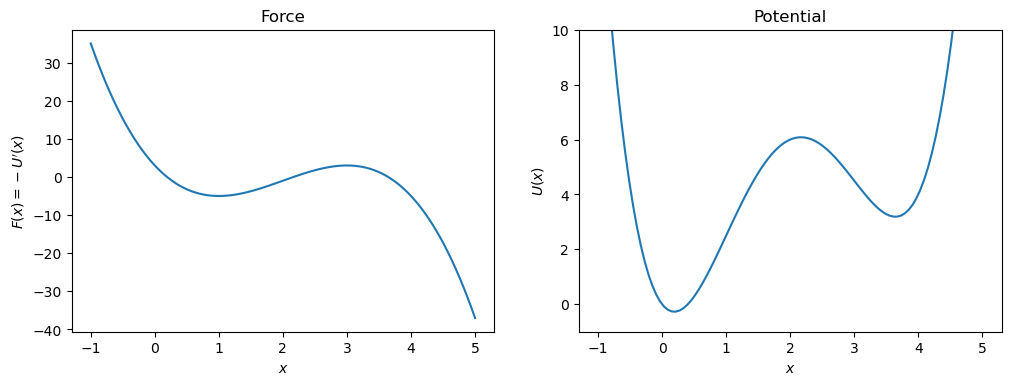

In [2]:
F = lambda x : 3 - 18*x  + 12*x**2 - 2*x**3
U = lambda x : -3*x + 9*x**2 - 4*x**3 + 0.5*x**4
x = np.linspace(-1,5,100)
fig, axs = plt.subplots(1,2, figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
axs[0].plot(x,F(x))
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x) = -U'(x)$")
axs[0].set_title("Force")
axs[1].plot(x,U(x))
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$U(x)$")
axs[1].set_ylim([-1,10])
axs[1].set_title("Potential")
plt.show()

The paper describes simulating 5 trajectories of $N = 10^7$ steps with time increment $\Delta t = 5 \cdot 10^{-3}$ and diffusion coefficient $D = 1$. The initial conditions are not specified, but the long time series ensures that they are not very important.

As a result, we have a tall 5-column matrix $x_\text{multiple}$ containing the time series of the 5 trajectories.

In [3]:
x_multiple = []
dt = 5e-3
n = int(5e6)
n_traj = 5
diffusion = 1
x0s = np.full(n_traj, 2) # all trajectories start at x=2
# x0s = np.linspace(0,4,n_traj)

def mp_ts(x0):
    np.random.seed()
    return time_series(F,x0,dt,n,diffusion)

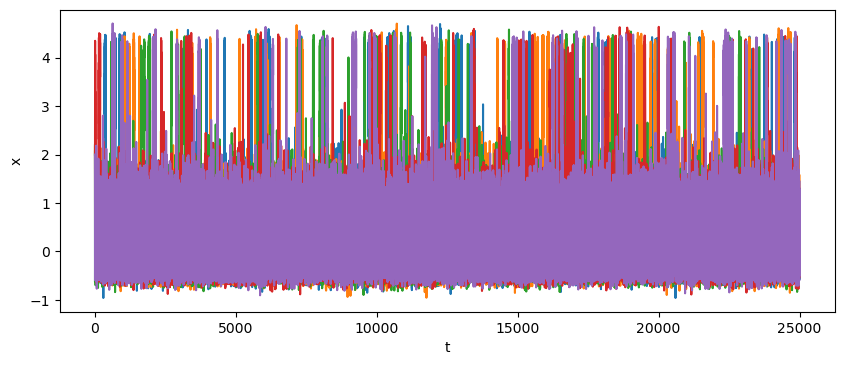

In [4]:
pool = mp.Pool()
x_multiple = pool.map(mp_ts, x0s)
pool.close()
pool.join()

fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(n_traj):
    plt.plot(np.linspace(0,n*dt,n+1), x_multiple[i])
plt.ylabel("x")
plt.xlabel("t")
plt.show()

x_multiple = np.array(x_multiple).T

The instantaneous velocities are computed using the explicit Euler scheme and stored in the tall 5-column matrix $Y_\text{multiple}$ according to the respective points in the time series matrix $x_\text{multiple}$.

Each of these matrices are transformed into column vectors by stacking their columns, resulting in the two vectors $x_\text{single}$ and $Y_\text{single}$.

In [5]:
Y_multiple = ps.differentiation.FiniteDifference(order = 1)._differentiate(
    x_multiple, dt
)

# Stack the data into one column
Y_single = Y_multiple.reshape(-1, 1, order = 'F')
x_single = x_multiple.reshape(-1, 1, order = 'F')

## First set of basis functions

The paper explores its algorithm on two dictionaries with $K = 20$ (allegedly) basis functions:

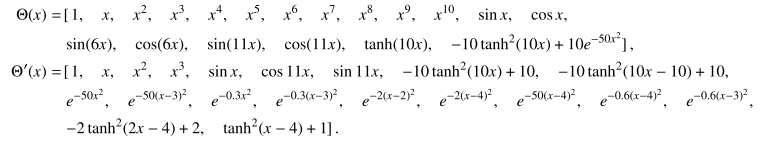

Note that $\Theta(x)$ actually has $K = 19$ functions.

Let us start with the first dictionary $\Theta(x)$.

In [6]:
basis1_fns = [
    lambda x : 1,
    lambda x : x,
    lambda x : x**2,
    lambda x : x**3,
    lambda x : x**4,
    lambda x : x**5,
    lambda x : x**6,
    lambda x : x**7,
    lambda x : x**8,
    lambda x : x**9,
    lambda x : x**10,
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x : np.sin(6*x),
    lambda x : np.cos(6*x),
    lambda x : np.sin(11*x),
    lambda x : np.cos(11*x),
    lambda x : np.tanh(10*x),
    lambda x : -10*np.tanh(10*x)**2 + 10*np.exp(-50*x**2)
]
basis1_names = [
    lambda x : '1',
    lambda x : x,
    lambda x : x+'^2',
    lambda x : x+'^3',
    lambda x : x+'^4',
    lambda x : x+'^5',
    lambda x : x+'^6',
    lambda x : x+'^7',
    lambda x : x+'^8',
    lambda x : x+'^9',
    lambda x : x+'^10',
    lambda x : 'sin('+x+')',
    lambda x : 'cos('+x+')',
    lambda x : 'sin(6*'+x+')',
    lambda x : 'cos(6*'+x+')',
    lambda x : 'sin(11*'+x+')',
    lambda x : 'cos(11*'+x+')',
    lambda x : 'tanh(10*'+x+')',
    lambda x : '-10 tanh(10*'+x+'$)^2$ + 10 exp(-50*'+x+'$**2$)'
]

basis1 = ps.CustomLibrary(
    library_functions=basis1_fns, function_names=basis1_names
)

To reduce the size of the problem, we condense the data from time series by binning. In particular, the paper chooses $Q = 90$ bins.The centres of the bins are thus stored in the column $x_\text{binned}$ and represent the new positions, whereas the velocities corresponding to each bin are averaged to obtain a similar column $Y_\text{binned}$. An array of weights are computed as the fractions of points from the time series that each bin has captured.

The basis functions can thus be evaluated at the binned positions $x_\text{binned}$ to obtain the matrix $X_\text{binned}$. A matrix of the weights $W$ is constructed as the diagonal matrix of the weight array.

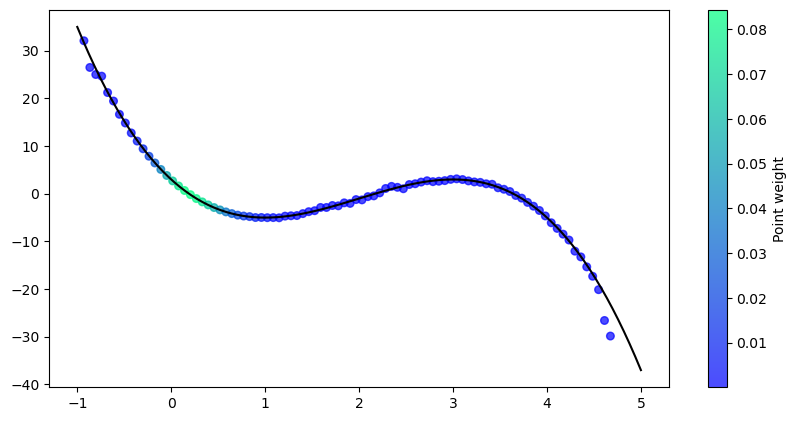

In [7]:
x_binned, Y_binned, weights = bin_data(x_single, Y_single, 90,
                                       width_type = 'equal')
basis1.fit(x_binned)
X_binned = basis1.transform(x_binned)
W = np.diag(weights)

fig = plt.figure(figsize = (10, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(x_binned.squeeze(), Y_binned.squeeze(), s = 30*(weights > 0), 
            marker = 'o', c = weights, cmap = 'winter', alpha = .7)
cbar = plt.colorbar()
cbar.set_label("Point weight")
plt.plot(x,F(x), 'k')

plt.show()

The paper then describes running their algorithm for $n_\text{runs} = 50$ times under different combinations of cross validation with 5 folds. The squared cross validation scores are averaged to get the final $\delta$'s.

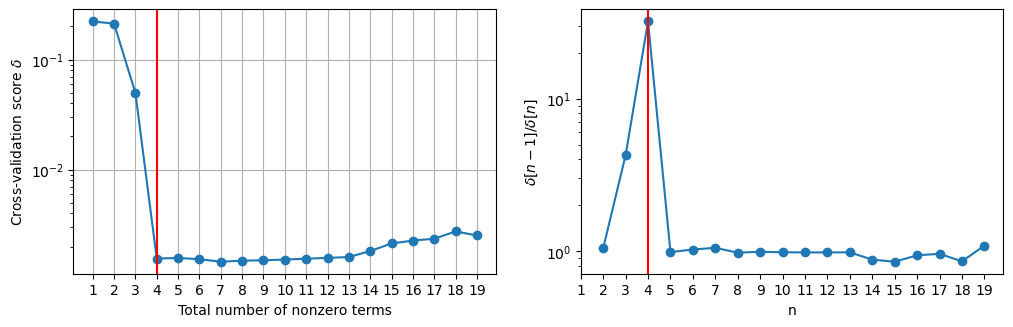

In [8]:
n_runs = 50
n_fns = X_binned.shape[1]

errors2 = np.zeros(n_fns)
for run in range(n_runs):
    errors2 += np.array(CV_scores(np.matmul(W,X_binned), np.matmul(W,Y_binned), K=5))
errors = np.sqrt(errors2/n_runs)
    
error_ratios = errors[:-1]/errors[1:]
opt_n = np.argmax(error_ratios[:-1]/error_ratios[1:])+2


fig, axs = plt.subplots(1,2,figsize=(12,3.5), dpi= 100, facecolor='w', edgecolor='k')

axs[0].set_xticks(np.arange(1,n_fns+1,1))
axs[0].semilogy(np.arange(1, n_fns * Y_binned.shape[1] + 1, 1), errors, '-o')
axs[0].set_xlabel("Total number of nonzero terms")
axs[0].set_ylabel("Cross-validation score $\delta$")
axs[0].axvline(x=opt_n, color = 'red')
axs[0].grid(True)

axs[1].semilogy(np.arange(2, n_fns * Y_binned.shape[1] + 1, 1), error_ratios, '-o')
axs[1].set_xticks(np.arange(1,n_fns+1,1))
axs[1].set_xlabel("n")
axs[1].set_ylabel("$\delta[n-1]/\delta[n]$")
axs[1].axvline(x=opt_n, color = 'red')

plt.show()

Compare to the paper's result:
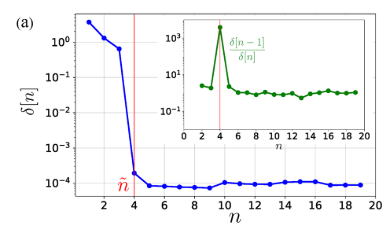

We thus use the found optimal value of number of terms $n$ to find the optimal set of functions:

The optimal set of basis functions is  ['1' 'x' 'x^2' 'x^3']


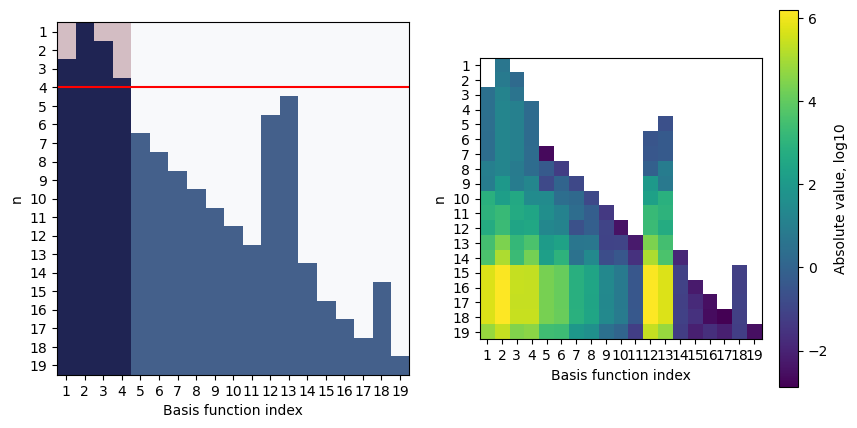

In [9]:
coeffs, masks, errors = SSR(np.matmul(W,X_binned), np.matmul(W,Y_binned))
m = masks.squeeze()

extent = [.5,n_fns+.5,n_fns+.5,.5]

fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
im1 = axs[0].imshow(m, cmap = 'Blues', extent = extent)

opt_fns_mask = np.array(m[opt_n-1,:], dtype = bool)
opt_fns = np.array(basis1.get_feature_names("x"))[opt_fns_mask]
print("The optimal set of basis functions is ", opt_fns)

opt_fns_m = np.array([opt_fns_mask for i in range(n_fns)])
im2 = axs[0].imshow(opt_fns_m, cmap = 'Reds', alpha = 0.25, extent = extent)

axs[0].axhline(y=opt_n, color = 'red')

axs[0].set_xticks(np.arange(1,n_fns+1,1))
axs[0].set_yticks(np.arange(1,n_fns+1,1))
axs[0].set_xlabel("Basis function index")
axs[0].set_ylabel("n")

c = np.abs(coeffs.squeeze())
c[~m] = None
c = np.log10(c)

rplot = axs[1].imshow(c, cmap = 'viridis', extent = extent)
cbar = fig.colorbar(rplot)
cbar.set_label("Absolute value, log10")


axs[1].set_xticks(np.arange(1,n_fns+1,1))
axs[1].set_yticks(np.arange(1,n_fns+1,1))
axs[1].set_xlabel("Basis function index")
axs[1].set_ylabel("n")

plt.show()

where the paper's sparsity progress matrix is presented as
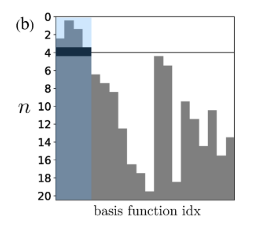

Finally, we compute the coefficients for these functions and thus obtain the predicted form of the force function:

Prediction: F(x) =  [  2.97599296 -17.86033276  11.81927713  -1.96060229] * ['1' 'x' 'x^2' 'x^3']


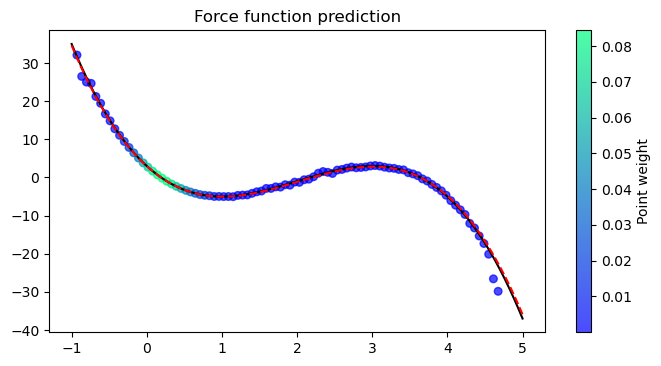

In [10]:
c_opt = coeffs.squeeze()[opt_n-1, opt_fns_mask]
print('Prediction: F(x) = ', str(c_opt.T)+' *',np.array(basis1.get_feature_names("x"))[opt_fns_mask])

plt.figure(figsize=(8,4), dpi= 100)

plt.plot(x,F(x), 'k')

F_pred = np.zeros_like(x)
for i in range(opt_n):
    F_pred += c_opt[i]*np.array(basis1_fns)[opt_fns_mask][i](x)
plt.plot(x,F_pred, 'r--')

plt.scatter(x_binned.squeeze(), Y_binned.squeeze(), s = 30*(weights > 0), 
            marker = 'o', c = weights, cmap = 'winter', alpha = .7)
cbar = plt.colorbar()
cbar.set_label("Point weight")

plt.title("Force function prediction")

plt.show()

Let us now compare this optimal prediction with the previous and the next guess in the SSR generated sequence.

Before: F(x) =  [  2.87768576 -14.56057825   3.92858735] * ['1' 'x' 'x^2']
Optimal: F(x) =  [  2.97599296 -17.86033276  11.81927713  -1.96060229] * ['1' 'x' 'x^2' 'x^3']
After: F(x) =  [  2.75165608 -17.86151683  11.94657254  -1.98668448   0.22408501] * ['1' 'x' 'x^2' 'x^3' 'cos(x)']


Text(0.5, 1.0, 'N = 5')

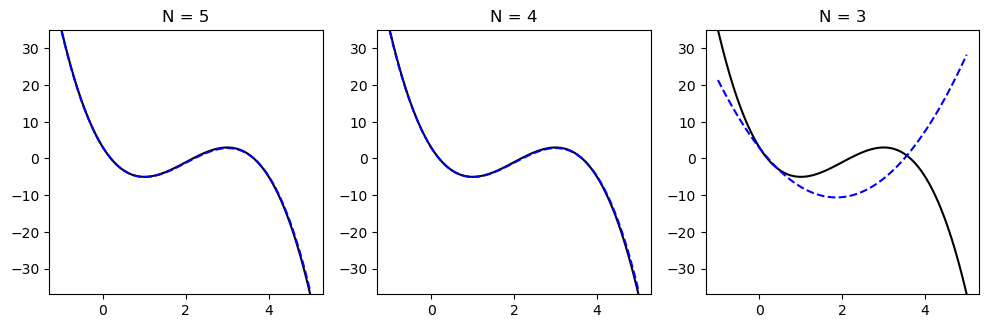

In [11]:
before_fns_mask = np.array(m[opt_n-2,:], dtype = bool)
before_fns = np.array(basis1.get_feature_names("x"))[before_fns_mask]
c_before = coeffs.squeeze()[opt_n-2, before_fns_mask]
F_before = np.zeros_like(x)
for i in range(opt_n-1):
    F_before += c_before[i]*np.array(basis1_fns)[before_fns_mask][i](x)

after_fns_mask = np.array(m[opt_n,:], dtype = bool)
after_fns = np.array(basis1.get_feature_names("x"))[after_fns_mask]
c_after = coeffs.squeeze()[opt_n, after_fns_mask]
F_after = np.zeros_like(x)
for i in range(opt_n+1):
    F_after += c_after[i]*np.array(basis1_fns)[after_fns_mask][i](x)


print('Before: F(x) = ', str(c_before.T)+' *',np.array(basis1.get_feature_names("x"))[before_fns_mask])
print('Optimal: F(x) = ', str(c_opt.T)+' *',np.array(basis1.get_feature_names("x"))[opt_fns_mask])
print('After: F(x) = ', str(c_after.T)+' *',np.array(basis1.get_feature_names("x"))[after_fns_mask])

fig, axs = plt.subplots(1,3,figsize=(12,3.5), dpi= 100, facecolor='w', edgecolor='k')

axs[2].plot(x,F(x), 'k')
axs[2].plot(x,F_before, 'b--')
axs[2].set_ylim([np.min(F(x)), np.max(F(x))])
axs[2].set_title(f"N = {opt_n-1}")

axs[1].plot(x,F(x), 'k')
axs[1].plot(x,F_pred, 'b--')
axs[1].set_ylim([np.min(F(x)), np.max(F(x))])
axs[1].set_title(f"N = {opt_n}")

axs[0].plot(x,F(x), 'k')
axs[0].plot(x,F_after, 'b--')
axs[0].set_ylim([np.min(F(x)), np.max(F(x))])
axs[0].set_title(f"N = {opt_n+1}")

For reference, the paper presented
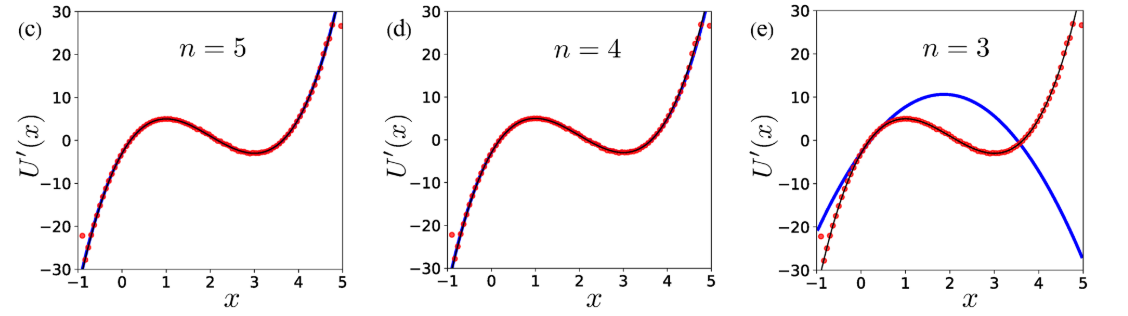

## Second set of basis functions

We now repreat this process for the other dictionary of basis functions $\Theta'(x)$:
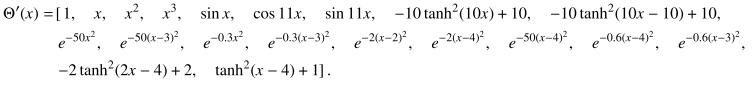

In [12]:
basis2_fns = [
    lambda x : 1,
    lambda x : x,
    lambda x : x**2,
    lambda x : x**3,
    lambda x : np.sin(x),
    lambda x : np.cos(11*x),
    lambda x : np.sin(11*x),
    lambda x : 10*(1-np.tanh(10*x)**2),
    lambda x : 10*(1-np.tanh(10*x-10)**2),
    lambda x : np.exp(-50*x**2),
    lambda x : np.exp(-50*(x-3)**2),
    lambda x : np.exp(-0.3*x**2),
    lambda x : np.exp(-0.3*(x-3)**2),
    lambda x : np.exp(-2*(x-2)**2),
    lambda x : np.exp(-2*(x-4)**2),
    lambda x : np.exp(-50*(x-4)**2),
    lambda x : np.exp(-0.6*(x-4)**2),
    lambda x : np.exp(-0.6*(x-3)**2),
    lambda x : 2*(1-np.tanh(2*x-4)**2),
    lambda x : np.tanh(x-4)**2+1,
]
basis2_names = [
    lambda x : '1',
    lambda x : x,
    lambda x : x+'^2',
    lambda x : x+'^3',
    lambda x : 'sin('+x+')',
    lambda x : 'cos(11*'+x+')',
    lambda x : 'sin(11*'+x+')',
    lambda x : '10(1-tanh(10*'+x+')^2)',
    lambda x : '10(1-tanh(10*'+x+'-10)^2)',
    lambda x : 'exp(-50*'+x+'^2)',
    lambda x : 'exp(-50('+x+'-3)^2)',
    lambda x : 'exp(-0.3*'+x+'^2)',
    lambda x : 'exp(-0.3('+x+'-3)^2)',
    lambda x : 'exp(-2('+x+'-2)^2)',
    lambda x : 'exp(-2('+x+'-4)^2)',
    lambda x : 'exp(-50('+x+'-4)^2)',
    lambda x : 'exp(-0.6('+x+'-4)^2)',
    lambda x : 'exp(-0.6('+x+'-3)^2)',
    lambda x : '2*(1-tanh(2*'+x+'-4)^2)',
    lambda x : 'tanh('+x+'-4)^2+1'
]

basis2 = ps.CustomLibrary(
    library_functions=basis2_fns, function_names=basis2_names
)

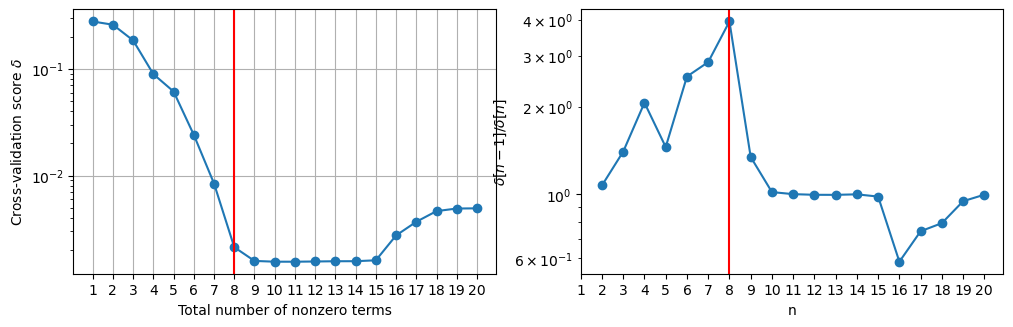

In [13]:
basis2.fit(x_binned)
X_binned = basis2.transform(x_binned)
W = np.diag(weights)

n_runs = 50
n_fns = X_binned.shape[1]

errors2 = np.zeros(n_fns)
for run in range(n_runs):
    errors2 += np.array(CV_scores(np.matmul(W,X_binned), np.matmul(W,Y_binned), K=5))
errors = np.sqrt(errors2/n_runs)
# errors = np.sqrt(errors2)/n_runs

    
error_ratios = errors[:-1]/errors[1:]
opt_n = np.argmax(error_ratios[:-1]/error_ratios[1:])+2


fig, axs = plt.subplots(1,2,figsize=(12,3.5), dpi= 100, facecolor='w', edgecolor='k')

axs[0].set_xticks(np.arange(1,n_fns+1,1))
axs[0].semilogy(np.arange(1, n_fns * Y_binned.shape[1] + 1, 1), errors, '-o')
axs[0].set_xlabel("Total number of nonzero terms")
axs[0].set_ylabel("Cross-validation score $\delta$")
axs[0].axvline(x=opt_n, color = 'red')
axs[0].grid(True)

axs[1].semilogy(np.arange(2, n_fns * Y_binned.shape[1] + 1, 1), error_ratios, '-o')
axs[1].set_xticks(np.arange(1,n_fns+1,1))
axs[1].set_xlabel("n")
axs[1].set_ylabel("$\delta[n-1]/\delta[n]$")
axs[1].axvline(x=opt_n, color = 'red')

plt.show()

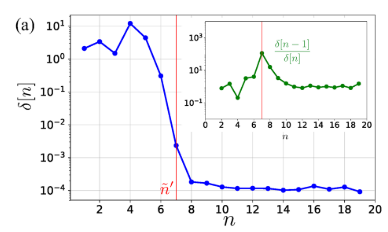

The optimal set of basis functions is  ['1' 'x' 'x^2' 'sin(x)' 'exp(-0.3(x-3)^2)' 'exp(-0.6(x-4)^2)'
 'exp(-0.6(x-3)^2)' 'tanh(x-4)^2+1']


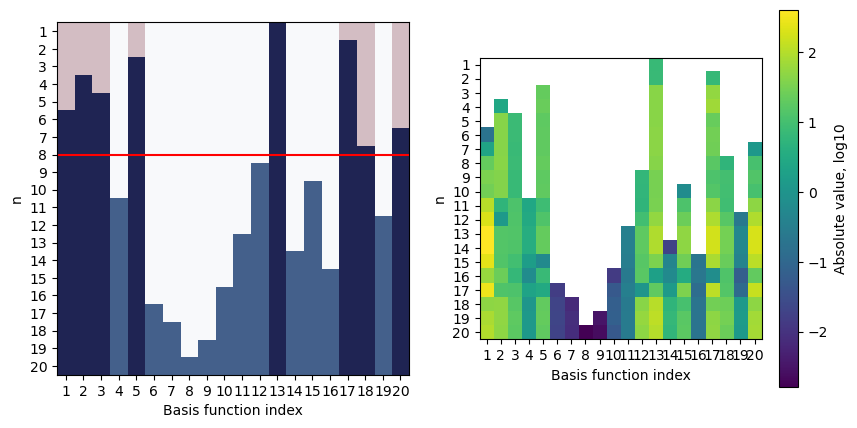

In [14]:
coeffs, masks, errors = SSR(np.matmul(W,X_binned), np.matmul(W,Y_binned))
m = masks.squeeze()

extent = [.5,n_fns+.5,n_fns+.5,.5]

fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
im1 = axs[0].imshow(m, cmap = 'Blues', extent = extent)

opt_fns_mask = np.array(m[opt_n-1,:], dtype = bool)
opt_fns = np.array(basis2.get_feature_names("x"))[opt_fns_mask]
print("The optimal set of basis functions is ", opt_fns)

opt_fns_m = np.array([opt_fns_mask for i in range(n_fns)])
im2 = axs[0].imshow(opt_fns_m, cmap = 'Reds', alpha = 0.25, extent = extent)

axs[0].axhline(y=opt_n, color = 'red')

axs[0].set_xticks(np.arange(1,n_fns+1,1))
axs[0].set_yticks(np.arange(1,n_fns+1,1))
axs[0].set_xlabel("Basis function index")
axs[0].set_ylabel("n")

c = np.abs(coeffs.squeeze())
c[~m] = None
c = np.log10(c)

rplot = axs[1].imshow(c, cmap = 'viridis', extent = extent)
cbar = fig.colorbar(rplot)
cbar.set_label("Absolute value, log10")

axs[1].set_xticks(np.arange(1,n_fns+1,1))
axs[1].set_yticks(np.arange(1,n_fns+1,1))
axs[1].set_xlabel("Basis function index")
axs[1].set_ylabel("n")

plt.show()

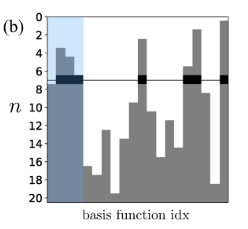

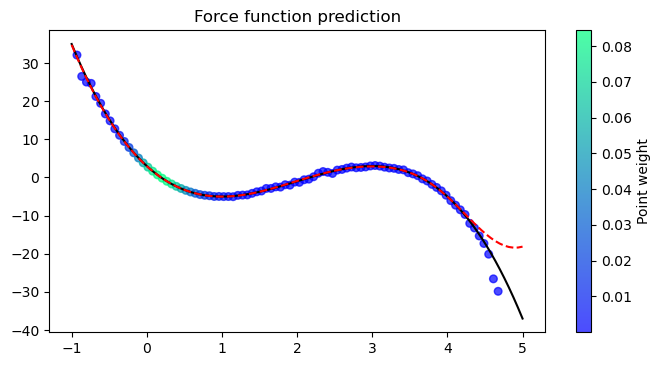

In [15]:
c_opt = coeffs.squeeze()[opt_n-1, opt_fns_mask]

plt.figure(figsize=(8,4), dpi= 100)

plt.plot(x,F(x), 'k')

F_pred = np.zeros_like(x)
for i in range(opt_n):
    F_pred += c_opt[i]*np.array(basis2_fns)[opt_fns_mask][i](x)
plt.plot(x,F_pred, 'r--')

plt.scatter(x_binned.squeeze(), Y_binned.squeeze(), s = 30*(weights > 0), 
            marker = 'o', c = weights, cmap = 'winter', alpha = .7)

cbar = plt.colorbar()
cbar.set_label("Point weight")
plt.title("Force function prediction")

plt.show()

In [16]:
print('Prediction: F(x) = ', str(c_opt.T)+' *',np.array(basis2.get_feature_names("x"))[opt_fns_mask])

Prediction: F(x) =  [ 21.88160728 -44.35734378   7.86802873  21.22231896  42.67622587
  16.9283008    5.54079586 -10.90783351] * ['1' 'x' 'x^2' 'sin(x)' 'exp(-0.3(x-3)^2)' 'exp(-0.6(x-4)^2)'
 'exp(-0.6(x-3)^2)' 'tanh(x-4)^2+1']


Before: F(x) =  [  2.25648169 -43.50586161   7.54922323  19.9291854   47.24703171
  27.28248643  -1.22940589] * ['1' 'x' 'x^2' 'sin(x)' 'exp(-0.3(x-3)^2)' 'exp(-0.6(x-4)^2)'
 'tanh(x-4)^2+1']
Optimal: F(x) =  [ 21.88160728 -44.35734378   7.86802873  21.22231896  42.67622587
  16.9283008    5.54079586 -10.90783351] * ['1' 'x' 'x^2' 'sin(x)' 'exp(-0.3(x-3)^2)' 'exp(-0.6(x-4)^2)'
 'exp(-0.6(x-3)^2)' 'tanh(x-4)^2+1']
After: F(x) =  [ 34.33596334 -40.7625723    6.91490046  18.94339062  -6.1254267
  31.08681085  12.56739367  10.03935463 -13.69439195] * ['1' 'x' 'x^2' 'sin(x)' 'exp(-0.3*x^2)' 'exp(-0.3(x-3)^2)'
 'exp(-0.6(x-4)^2)' 'exp(-0.6(x-3)^2)' 'tanh(x-4)^2+1']


Text(0.5, 1.0, 'N = 9')

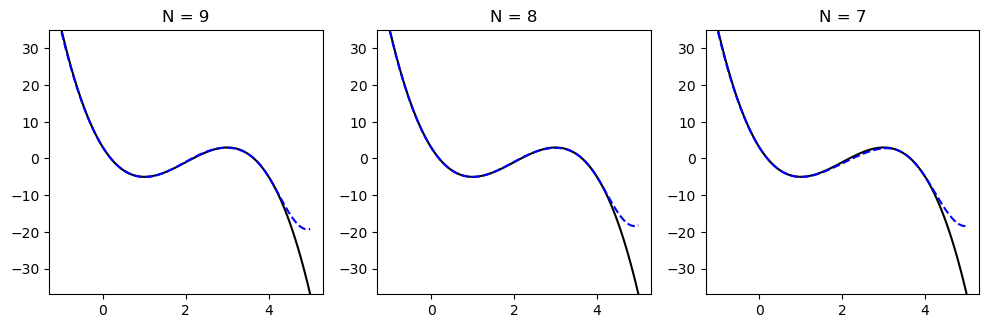

In [17]:
before_fns_mask = np.array(m[opt_n-2,:], dtype = bool)
before_fns = np.array(basis2.get_feature_names("x"))[before_fns_mask]
c_before = coeffs.squeeze()[opt_n-2, before_fns_mask]
F_before = np.zeros_like(x)
for i in range(opt_n-1):
    F_before += c_before[i]*np.array(basis2_fns)[before_fns_mask][i](x)

after_fns_mask = np.array(m[opt_n,:], dtype = bool)
after_fns = np.array(basis2.get_feature_names("x"))[after_fns_mask]
c_after = coeffs.squeeze()[opt_n, after_fns_mask]
F_after = np.zeros_like(x)
for i in range(opt_n+1):
    F_after += c_after[i]*np.array(basis2_fns)[after_fns_mask][i](x)


print('Before: F(x) = ', str(c_before.T)+' *',np.array(basis2.get_feature_names("x"))[before_fns_mask])
print('Optimal: F(x) = ', str(c_opt.T)+' *',np.array(basis2.get_feature_names("x"))[opt_fns_mask])
print('After: F(x) = ', str(c_after.T)+' *',np.array(basis2.get_feature_names("x"))[after_fns_mask])

fig, axs = plt.subplots(1,3,figsize=(12,3.5), dpi= 100, facecolor='w', edgecolor='k')

axs[2].plot(x,F(x), 'k')
axs[2].plot(x,F_before, 'b--')
axs[2].set_ylim([np.min(F(x)), np.max(F(x))])
axs[2].set_title(f"N = {opt_n-1}")

axs[1].plot(x,F(x), 'k')
axs[1].plot(x,F_pred, 'b--')
axs[1].set_ylim([np.min(F(x)), np.max(F(x))])
axs[1].set_title(f"N = {opt_n}")

axs[0].plot(x,F(x), 'k')
axs[0].plot(x,F_after, 'b--')
axs[0].set_ylim([np.min(F(x)), np.max(F(x))])
axs[0].set_title(f"N = {opt_n+1}")

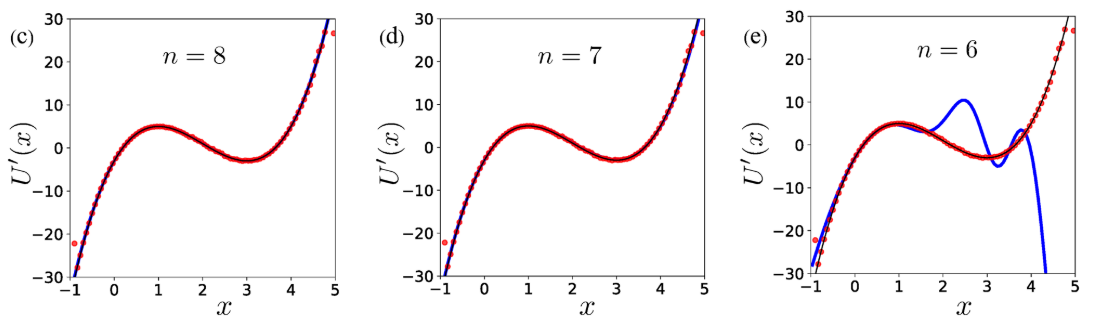

# Averaging results from multiple time series

In [18]:
# N = 5

# errors = np.zeros(len(basis1_fns))

# for _ in range(N):
#     # Generating time series
#     pool = mp.Pool()
#     x_multiple = pool.map(mp_ts, x0s)
#     pool.close()
#     pool.join()

#     # Computing derivatives
#     x_multiple = np.array(x_multiple).T
#     Y_multiple = ps.differentiation.FiniteDifference(order = 1)._differentiate(
#         x_multiple, dt
#     )

#     # Stack the data into one column
#     Y_single = Y_multiple.reshape(-1, 1, order = 'F')
#     x_single = x_multiple.reshape(-1, 1, order = 'F')

#     # Data binning
#     x_binned, Y_binned, weights = bin_data(x_single, Y_single, 90,
#                                            width_type = 'equal')

#     # Basis fitting
#     basis1.fit(x_binned)
#     X_binned = basis1.transform(x_binned)
#     W = np.diag(weights)

#     # Runnin SSR algorithm
#     n_runs = 50
#     n_fns = X_binned.shape[1]
#     errors2 = np.zeros(n_fns)
#     for run in range(n_runs):
#         errors2 += CV_scores(np.matmul(W,X_binned), np.matmul(W,Y_binned), K=5)
#     errors += np.sqrt(errors2/n_runs)
    
# errors = np.sqrt(errors**2/N)

In [19]:
# fig = plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
# plt.semilogy(np.arange(1, len(basis1_fns) * Y_binned.shape[1] + 1, 1), errors, '-o')
# plt.show()